In [1]:
##########################
studies = [
    { 'study_name' : 'ac2', 'study_time' : 1200 },
    { 'study_name' : 'chi19s2', 'study_time' : 900 },
    { 'study_name' : 'chi19s3', 'study_time' : 1500 },
    { 'study_name' : 'iui20', 'study_time' : 600 }
]
min_idea_submits = 3

# Must not be smaller than sliding_window
bucket_length = 60

# Sliding window defaults to bucket_length if <0
sliding_window = 10



In [3]:
##########################

def get_types(filtered_data, timer_value):
    median = get_median_requests(filtered_data, timer_value)
    column_name = str(timer_value) + '-inspirationRequestTimers'
    seekers = filtered_data[filtered_data[column_name] > median]["workerId"]
    avoiders = filtered_data[filtered_data[column_name] <= 2]["workerId"]
    return {'seekers': seekers, 'avoiders': avoiders}
    

In [4]:
def get_events_per_type(study, types):
    submits = pd.read_csv(study['study_name'] + '_ideaSubmits.csv', sep=';')
    requests = pd.read_csv(study['study_name'] + '_inspirationRequests.csv', sep=';')
    return {
        'avoiders': [
            submits[submits['workerId'].isin(types['avoiders'])],
            requests[requests['workerId'].isin(types['avoiders'])]
        ],
        'seekers': [
            submits[submits['workerId'].isin(types['seekers'])],
            requests[requests['workerId'].isin(types['seekers'])]
        ]
    }

def get_event_data(submits_table, requests_table):        
    submits_table = submits_table.drop(columns = "workerId")
    requests_table = requests_table.drop(columns = "workerId")
    event_data = []
    for i in range(len(submits_table)):
        event_data.append(create_bucket(submits_table.iloc[i,:], requests_table.iloc[i,:]))
    return event_data

def create_bucket(submitsRow, requestsRow):
    results = []
    i = 0
    while i < submitsRow.size:
        result = sum(submitsRow[i:i+bucket_length])
        results.append(result)
        i+=bucket_length
    i = 0
    while i < requestsRow.size:
        result = sum(requestsRow[i:i+bucket_length])
        results.append(result)
        i+=bucket_length
    return results

def get_result(events_per_type): 
    # input {'avoiders': [[submits x seconds: 0, 0, 0, 1, 1, 0], [requests x seconds: 0, 0, 0, 1, 1, 0]], ...}
    # output {'avoiders': [submits x bucket_length: 0, 4, 2], [requests x bucket_length: 0, 2, 0]}
    avoiders = get_event_data(events_per_type['avoiders'][0], events_per_type['avoiders'][1])
    seekers = get_event_data(events_per_type['seekers'][0], events_per_type['seekers'][1])
    return {
        'avoiders': avoiders,
        'seekers': seekers
    }


def get_results_for_all_studies(): 
    results = {}
    for study in studies:
        filtered_data = filter_by_idea_submits(study['study_name'], study['study_time'], min_idea_submits)
        # TODO: fill data up with 0s
        
        types = get_types(filtered_data, study['study_time'])
        
        # {'avoiders': [[submits], [requests], ], ...}
        events_per_type = get_events_per_type(study, types)
        
        result = get_result(events_per_type)
        results[study['study_name']] = result
    return results

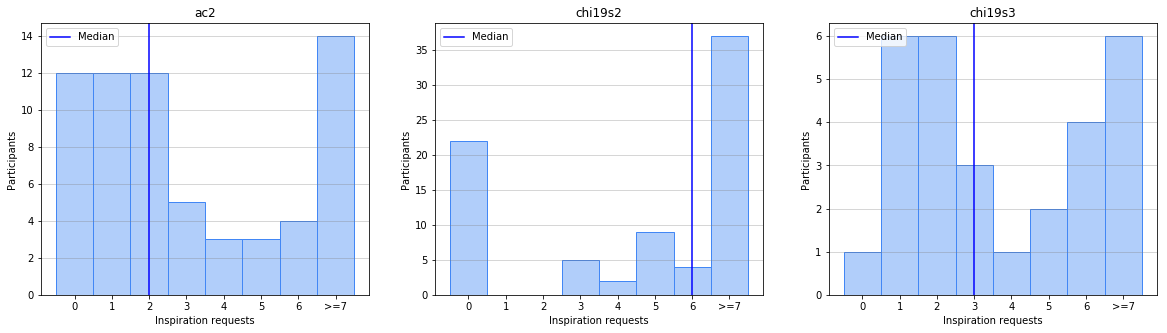

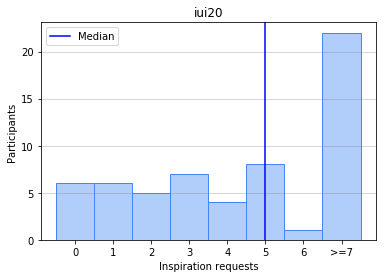

In [118]:
def print_histogram(study, max_buckets, xlabel, column_name, ideator_type = None):
    filtered_data = filter_by_idea_submits(study['study_name'], study['study_time'], min_idea_submits)
    title = study['study_name']
    if ideator_type is not None:
        workers_per_type = get_types(filtered_data, study['study_time'])
        filtered_data = filtered_data[filtered_data['workerId'].isin(workers_per_type[ideator_type])]
        title =  title + ' (' + ideator_type + ' only)'
    med = get_median_requests(filtered_data, study['study_time'])
    if column_name == '-ideaSubmitTimers':
        med = get_median_submits(filtered_data, study['study_time'])
    clipped_data = np.clip(filtered_data[str(study['study_time']) + column_name], 0, max_buckets)
    plt.hist(clipped_data, bins=max_buckets, color = "#b1cefa", edgecolor='#4287f5', range=(0, max_buckets))
    xticks = np.append(np.arange(0, max_buckets - 1), ">=" + str(max_buckets - 1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Participants')
    plt.xticks(np.arange(max_buckets) + 0.5, labels = xticks)
    plt.axvline(med + 0.5, color = "blue", label = 'Median')
    plt.grid(axis='y', alpha = 0.4, color = "gray")
    plt.legend(loc = 'upper left')


def print_requests_histogram(study):
    print_histogram(study, max_buckets = 8, xlabel = 'Inspiration requests', column_name = '-inspirationRequestTimers')


fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1,3,1)
print_requests_histogram(studies[0])
fig.add_subplot(1,3,2)
print_requests_histogram(studies[1])
fig.add_subplot(1,3,3)
print_requests_histogram(studies[2])
plt.show()
fig.savefig("previousStudies-inspirationRequests-histogram.pdf", bbox_inches='tight')
histogram = plt.figure()
print_requests_histogram(studies[3])
plt.show()
histogram.savefig("iui20-inspirationRequests-histogram.pdf", bbox_inches='tight')

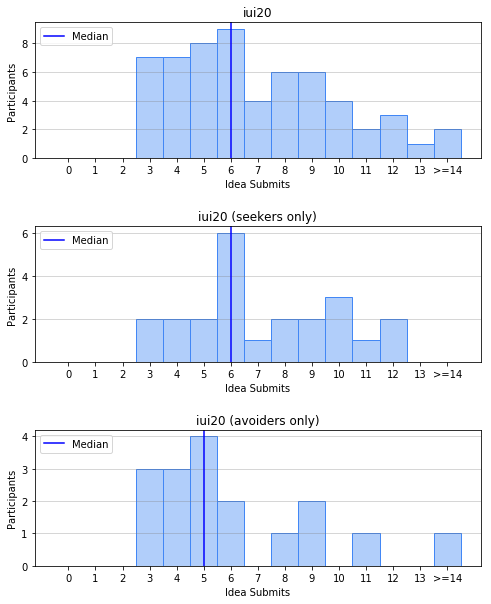

In [112]:
def print_submits_histogram_per_type(study, ideator_type):
    print_histogram(study, max_buckets = 15, xlabel = 'Idea Submits',
                    column_name = '-ideaSubmitTimers', ideator_type = ideator_type)

    

fig = plt.figure(figsize=(8, 10))
fig.add_subplot(3,1,1)
print_submits_histogram(studies[3])
fig.add_subplot(3,1,2)
print_submits_histogram_per_type(studies[3], 'seekers')
fig.add_subplot(3,1,3)
print_submits_histogram_per_type(studies[3], 'avoiders')
fig.subplots_adjust(hspace = 0.5)
plt.show()
fig.savefig("iui20-ideaSubmits-perType-histogram.pdf", bbox_inches='tight')

In [8]:
all_studies = get_results_for_all_studies()
# determine matrix size
# nr of buckets = max number of buckets
max_bucket_size = 0
for study_name in all_studies.keys():
    max_bucket_size = max(max_bucket_size, len(all_studies[study_name]['avoiders'][0]))
# nr of lines = sum of lines
nr_lines = sum([len(all_studies[study_name][name]) for study_name in all_studies.keys() for name in ['avoiders', 'seekers']])
x, y = np.zeros((nr_lines, max_bucket_size)), np.zeros(nr_lines)
current_line = 0
for study_name in all_studies.keys():
    for y_value, type in enumerate(['avoiders', 'seekers']):
        type_results = np.array(all_studies[study_name][type])
        type_count = len(type_results)
        bucket_count = len(type_results[0])
        x[current_line:current_line+type_count,:bucket_count] += type_results
        y[current_line:current_line+type_count] = y_value 
        current_line += type_count

# Take perentage of the longest study: 
# e.g. longest study: 25m, 0.4% => cut after 10 minutes
def shorten_x(x, perc=0.5):
    nrows, ncols = x.shape
    # take x features apart by bins of submits and requests
    col_cut = int(ncols/2)
    x_submits, x_requests = x[:,:col_cut], x[:,col_cut:]
    # create return array
    cut_partial = int(perc*int(ncols/2))
    x_return = np.zeros((nrows, 2*cut_partial))
    x_return[:,:cut_partial] = x_submits[:,:cut_partial]
    x_return[:,cut_partial:] = x_requests[:,:cut_partial]
    return x_return

x_train, x_test, y_train, y_test = train_test_split(shorten_x(x, 0.4), y, test_size=0.25)
print('all:   ', x.shape, y.shape)
print('train: ', x_train.shape, y_train.shape)
print('test:  ', x_test.shape, y_test.shape)

all:    (190, 50) (190,)
train:  (142, 20) (142,)
test:   (48, 20) (48,)


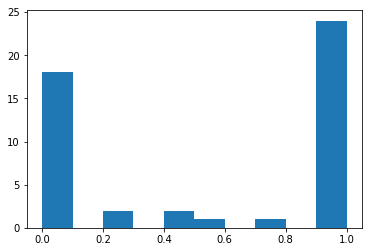

[1.   0.6  0.   1.   1.   1.   1.   0.   0.25 1.   1.   1.   1.   1.
 0.   0.   1.   0.   0.   0.   0.   1.   0.   1.   0.25 1.   1.   0.
 1.   1.   0.   1.   0.   1.   0.   1.   0.75 1.   0.   0.4  0.   1.
 1.   0.   1.   0.4  0.   0.  ]
[1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1
 1 0 0 0 1 1 0 1 0 0 0]
confusion matrix:
 [[16  6]
 [10 16]]


In [9]:
# trees offer readable rules
from sklearn.tree     import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# support vector machines (svm) allow for simple (but effective) classification
from sklearn.svm import SVC

# metric by which to measure the ml algorithm
from sklearn.metrics import confusion_matrix

# instantiate classifier
#clf = DecisionTreeClassifier(max_depth=10)
clf = DecisionTreeRegressor(max_depth=10)
#clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
#clf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=0)
#clf = SVC(kernel='linear')

# train classifier
clf.fit(x_train, y_train)

# get predicted classes
y_pred = clf.predict(x_test)
plt.hist(y_pred)
plt.show()
print(y_pred)
y_pred = np.array([0 if val<0.5 else 1 for val in y_pred])
print(y_pred)
print('confusion matrix:\n', confusion_matrix(y_pred, y_test))

In [10]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

# load the model from disk
clf2 = pickle.load(open(filename, 'rb'))
print(clf2)
y_pred = clf2.predict(x_test)
print(y_pred)

np.savetxt('xtest.txt', x_test)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
[1.   0.6  0.   1.   1.   1.   1.   0.   0.25 1.   1.   1.   1.   1.
 0.   0.   1.   0.   0.   0.   0.   1.   0.   1.   0.25 1.   1.   0.
 1.   1.   0.   1.   0.   1.   0.   1.   0.75 1.   0.   0.4  0.   1.
 1.   0.   1.   0.4  0.   0.  ]


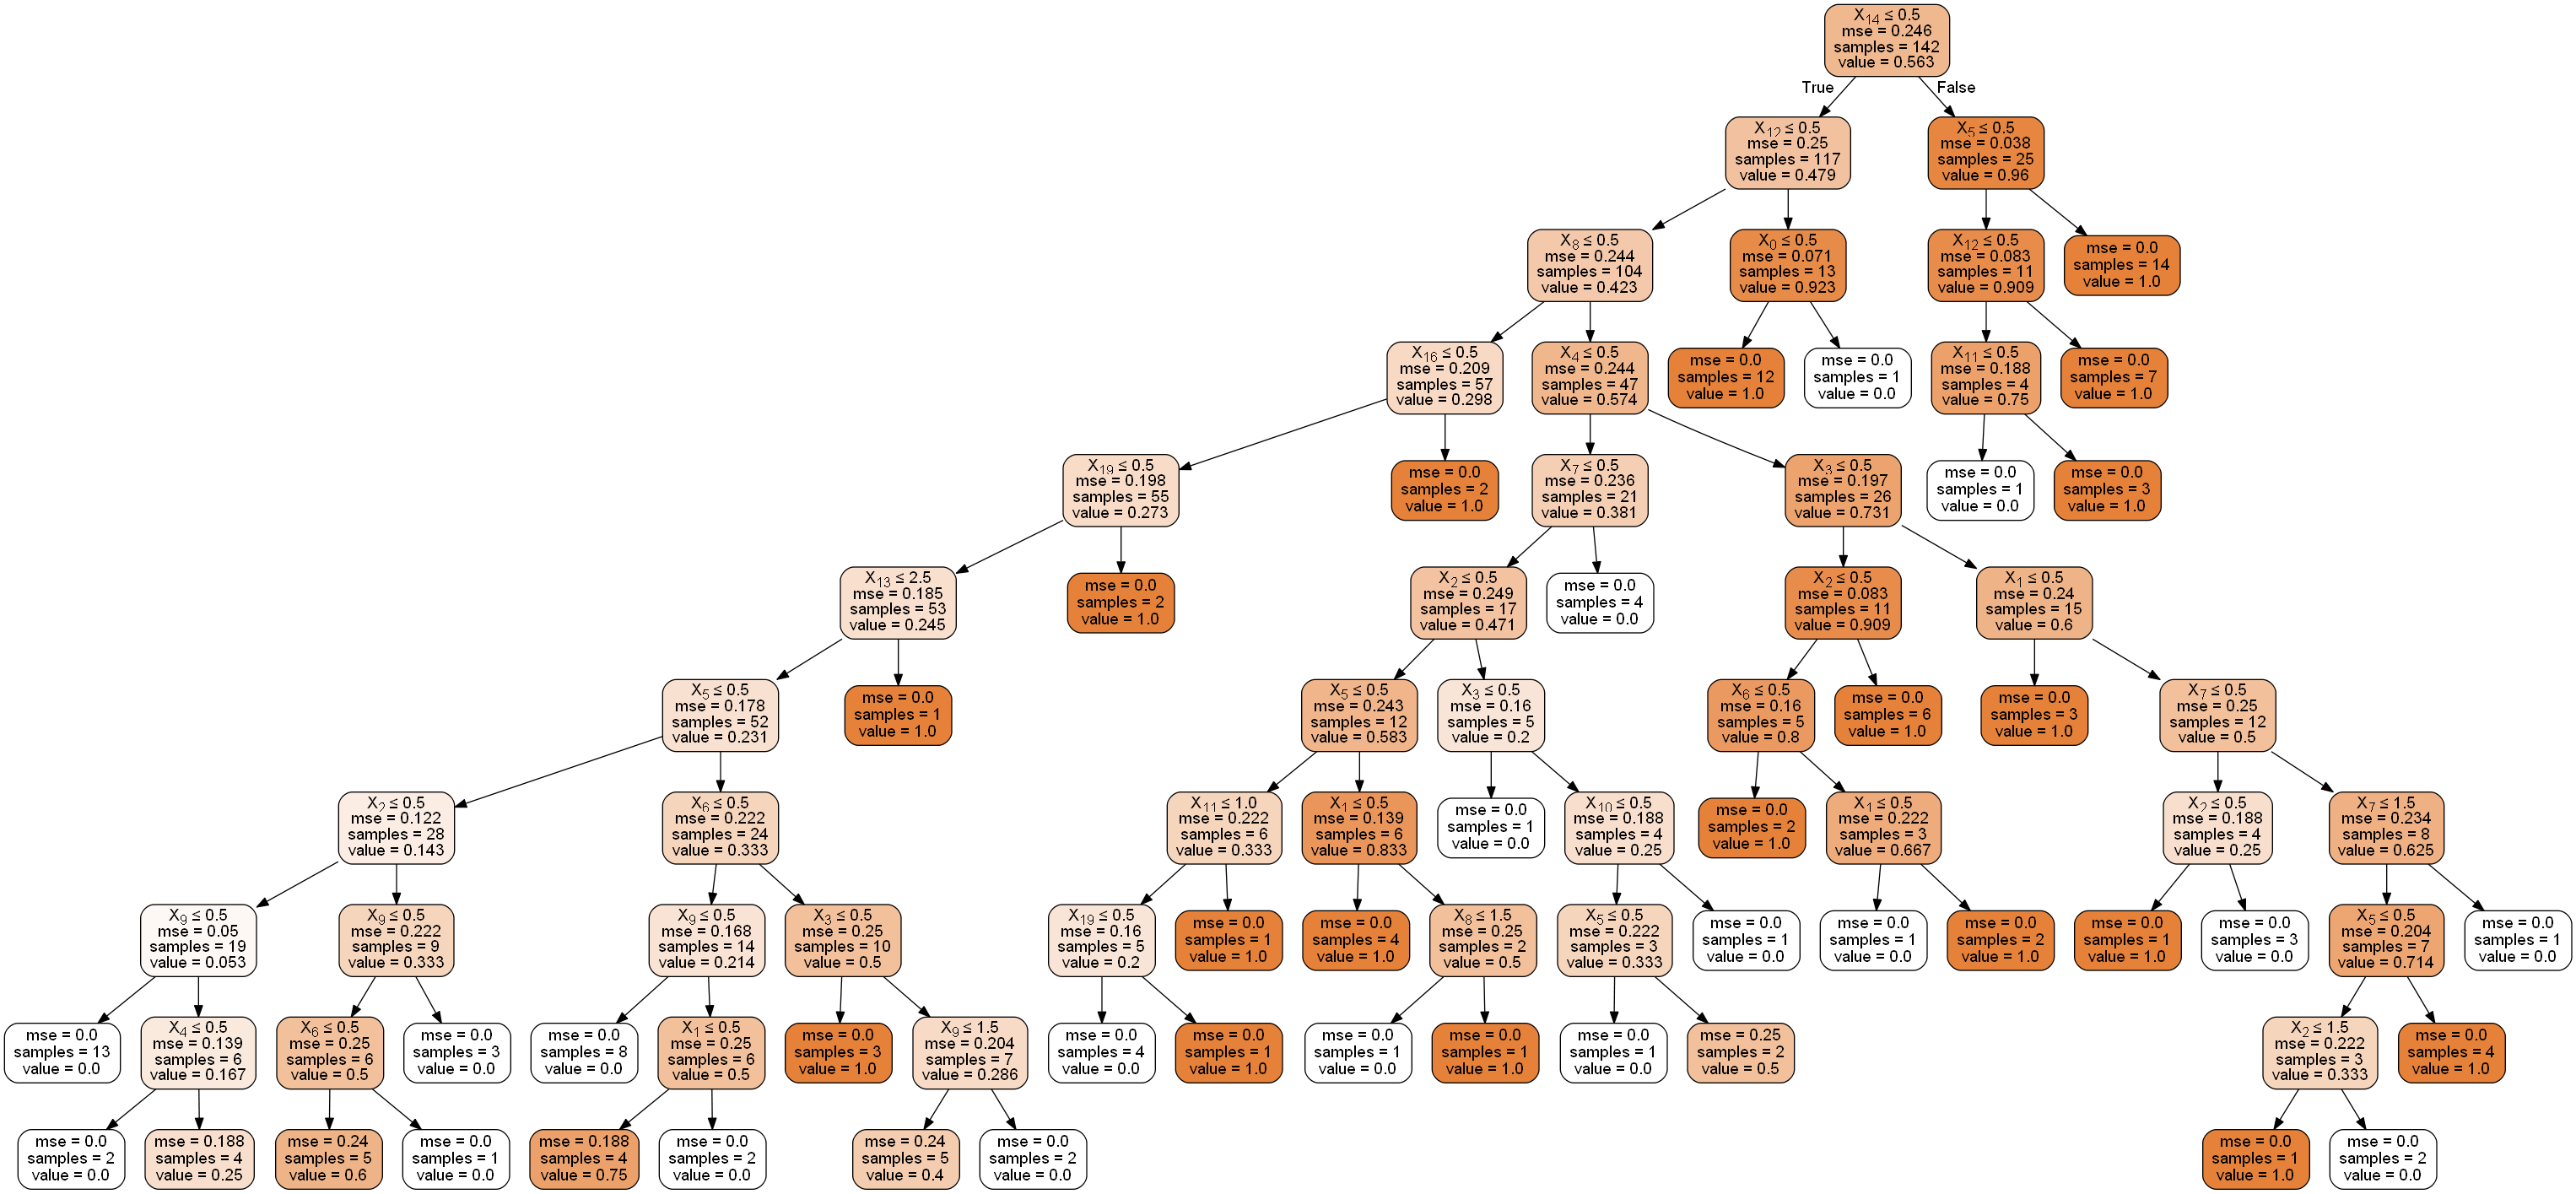

In [11]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


